## Restricted Boltzmann Machine for J1-J2 Heisenberg Model

#### **Importing the Packages**

- **NetKet**: The main library for building and training Neural Quantum States (NQS).

- **NumPy**: A fundamental library for numerical computations and vectorized math operations.

- **Matplotlib**: For visualizing data, plots, and training curves.

- **JAX**: A high-performance numerical computing library that provides automatic differentiation and XLA-accelerated execution on CPU/GPU/TPU. Essential for training neural-network wavefunctions.

- **Flax**: A neural network library built on top of JAX, used to define and manage neural-network models (such as NQS ansatzes)

In [18]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import netket as nk
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import flax.linen as nn
import netket.nn as nknn

#### Initialization of the $J_1$-$J_2$ Heisenberg Model Lattice

This section initializes the 2D lattice for the **frustrated $J_1$-$J_2$ Heisenberg model** using the NetKet library.

---

#### Lattice Dimensions

We set the linear size parameter to $\mathbf{L = 6}$, which produces a square lattice with:
$$
N = L^2 = 36
$$
sites.

---

#### Lattice Construction and Geometry

The lattice graph is constructed using a function like `nk.graph.Square()`. 

The key arguments for defining the lattice geometry are:

* **`length = L`**: Builds an $L \times L$ square lattice.
* **`max_neighbor_order = 2`**: This instructs NetKet to include:
    * **Order 1 neighbors ($\langle i,j\rangle$):** Nearest Neighbors (NN), corresponding to $J_1$.
    * **Order 2 neighbors ($\langle\!\langle i,j\rangle\!\rangle$):** Next-Nearest Neighbors (NNN), corresponding to $J_2$.
* **`pbc = True`**: Applies **Periodic Boundary Conditions (PBC)**, making the lattice topologically equivalent to a torus, where opposite edges are connected:
    $$
    (i_x, i_y) \sim (i_x + L, i_y), \qquad
    (i_x, i_y) \sim (i_x, i_y + L).
    $$

---

#### Hamiltonian and Coupling Constants

The coupling constants for the model are set to:
* $J_1 = 1.0$: nearest-neighbor interaction strength.
* $J_2 = 0.5$: next-nearest-neighbor interaction strength.

These parameters define the **frustrated Heisenberg Hamiltonian**:
$$
H = J_1 \sum_{\langle i,j\rangle} \mathbf{S}_i \cdot \mathbf{S}_j
  + J_2 \sum_{\langle\!\langle i,j\rangle\!\rangle} \mathbf{S}_i \cdot \mathbf{S}_j .
$$
This lattice object and the coupling constants will be used to construct the Heisenberg Hamiltonian programmatically in a subsequent step.


In [19]:
L = 6   
J1 = 1.0
J2 = 0.5

lattice = nk.graph.Square(length=L, max_neighbor_order=2, pbc=True)
print("Number of sites:", lattice.n_nodes)

Number of sites: 36


### Visualizing Edge Colors on the Lattice

NetKet represents the lattice as a graph:
- **nodes** = lattice sites
- **edges** = interactions (bonds) between sites
- **edge colors** = integer labels that distinguish different bond types

For example, in our case:
- color **0** → nearest-neighbor (NN) edges  
- color **1** → next-nearest-neighbor (NNN, diagonal) edges  

Below is a toy 3×3 lattice (just for illustration) with sites labeled 0–8.  
We show:
- horizontal and vertical bonds as **color 0**
- diagonal bonds as **color 1**

```text
    (0)──0──(1)──0──(2)
     | \   / | \   / |
     0   1   0   1   0
     | /   \ | /   \ |
    (3)──0──(4)──0──(5)
     | \   / | \   / |
     0   1   0   1   0
     | /   \ | /   \ |
    (6)──0──(7)──0──(8)

In [20]:
from collections import Counter

# Sequence of color indices, same order as lattice.edges()
edge_colors = lattice.edge_colors

print("Unique edge colors:", set(edge_colors))
print("Edges per type:", Counter(edge_colors))
print(edge_colors)

Unique edge colors: {0, 1}
Edges per type: Counter({0: 72, 1: 72})
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [21]:
edges = lattice.edges()  # returns (i, j) only
for (idx, (i, j)) in enumerate(edges[:10]):  # first 10 edges
    print(f"edge {idx}: ({i}, {j}), color = {edge_colors[idx]}")

edge 0: (24, 30), color = 0
edge 1: (0, 30), color = 0
edge 2: (6, 12), color = 0
edge 3: (15, 21), color = 0
edge 4: (1, 31), color = 0
edge 5: (3, 4), color = 0
edge 6: (18, 23), color = 0
edge 7: (26, 27), color = 0
edge 8: (16, 17), color = 0
edge 9: (12, 13), color = 0


### Defining the Hilbert Space

The **Hilbert space** ($\mathcal{H}$) for the simulation is constructed using `nk.hilbert.Spin`, which defines a system of quantum spins on all $N = 36$ lattice sites.

---

### Spin Specification and Dimension

For the $J_1$-$J_2$ Heisenberg model, each site carries a **spin-$\mathbf{\frac{1}{2}}$** degree of freedom, defined by the quantum number:
$$
S = \tfrac{1}{2}
$$
This results in two allowed $S^z$ eigenvalues per site: $m_s = \pm \frac{1}{2}$ (spin up or spin down). The total dimension of the full Hilbert space is:
$$
\dim(\mathcal{H}) = 2^N = 2^{36}
$$

---

### Symmetry Constraints: Zero-Magnetization Sector

To make the simulation computationally feasible while capturing the ground state physics, we typically impose a global constraint:
$$
\sum_i S_i^z = 0
$$
This is achieved using the argument `total_sz = 0.0` in the Hilbert space definition. This action restricts the dynamics to the **zero-magnetization sector** , where the true Heisenberg ground state is known to reside.


In [22]:
hilbert_space = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=lattice.n_nodes)

### Constructing the Heisenberg Hamiltonian

The **Hamiltonian operator** ($H$) is the core component of the simulation; its eigenvalues represent the system's possible energy values. We are constructing the frustrated $J_1$-$J_2$ Heisenberg Hamiltonian:
$$
H = J_1 \sum_{\langle i,j\rangle} \mathbf{S}_i \cdot \mathbf{S}_j + J_2 \sum_{\langle\!\langle i,j\rangle\!\rangle} \mathbf{S}_i \cdot \mathbf{S}_j
$$
where the interaction between two spins is the dot product:
$$
\mathbf{S}_i \cdot \mathbf{S}_j = S_i^x S_j^x + S_i^y S_j^y + S_i^z S_j^z .
$$


---

### Implementation Details: `nk.operator.Heisenberg`

NetKet generates this complex operator using the dedicated `nk.operator.Heisenberg` function, which requires the geometric and coupling information defined previously.

The function call effectively links the physics parameters to the lattice structure through the following arguments:

* **`hilbert`**: Specifies the Hilbert space ($\mathcal{H}$) (e.g., spin-$\frac{1}{2}$ in the zero-magnetization sector) on which the operator acts.
* **`graph`**: Provides the lattice structure, including the **edge colors** (0 for NN, 1 for NNN) that define the bond types and their connections.
* **`J=[J1, J2]`**: This argument links the numerical values of the coupling constants to the bonds:
    * $J_1 = 1.0$ is applied to all bonds with **color 0** (Nearest Neighbors).
    * $J_2 = 0.5$ is applied to all bonds with **color 1** (Next-Nearest Neighbors).
* **`sign_rule=[False, False]`**: This setting ensures the system uses the standard **antiferromagnetic (AFM)** sign for both the $J_1$ and $J_2$ interactions, consistent with the conventional definition where positive $J$ values denote AFM coupling in this specific operator.

The total number of terms in the Hamiltonian ($H$) is equal to the total number of bonds (NN + NNN) in the lattice graph, denoted by `hamiltonian.n_operators`.


In [23]:
hamiltonian = nk.operator.Heisenberg(
    hilbert=hilbert_space,
    graph=lattice,
    J=[J1, J2],
    sign_rule=[False, False],  
)

print("Number of terms in H:", hamiltonian.n_operators)

Number of terms in H: 144


In [24]:

rbm_model = nk.models.RBM(
    alpha=2,          # hidden-to-visible ratio
    use_hidden_bias=True,
    use_visible_bias=True,
)

### MetropolisExchange Sampler

To perform **Variational Monte Carlo (VMC)**, we must generate a sequence of spin configurations ($\sigma$) that are distributed according to the probability distribution given by the squared magnitude of our variational ansatz: $P(\sigma) = |\Psi_{\mathbf{\theta}}(\sigma)|^2$.

---

#### Preserving the Magnetization Constraint

Since the **Hilbert space** is explicitly constrained to the **zero-magnetization sector** ($\sum_i S_i^z = 0$), the Markov chain updates must strictly preserve this constraint.

* **Single-spin flips ($\uparrow \leftrightarrow \downarrow$) are forbidden:** Flipping a single spin changes the total magnetization by $\pm 1$ and would move the state outside the constrained Hilbert space.
* **The MetropolisExchange Sampler:** This sampler is designed to maintain the total magnetization by proposing moves that exchange the values of two spins, $\mathbf{S}_i$ and $\mathbf{S}_j$, that have opposite signs (e.g., swapping a $\uparrow$ and a $\downarrow$). 
    $$\sigma = (\dots, \uparrow_i, \dots, \downarrow_j, \dots) \quad \longrightarrow \quad \sigma' = (\dots, \downarrow_i, \dots, \uparrow_j, \dots)$$

This ensures that the number of up spins and down spins remains constant, thereby keeping the total magnetization at zero throughout the VMC sampling process.

In [25]:
sampler = nk.sampler.MetropolisExchange(
    hilbert=hilbert_space,
    graph=lattice,
    d_max=2,
)

### Defining the Variational Monte Carlo State (MCState)

The `MCState` object in NetKet is the central structure that encapsulates the variational quantum state ($\Psi_{\mathbf{\theta}}$) and the necessary Monte Carlo machinery. It combines the three core components required for running a Variational Monte Carlo (VMC) simulation.

---

#### Components of the `MCState`

The variational quantum state is mathematically represented by the function $\Psi_{\mathbf{\theta}}(\sigma)$, where $\mathbf{\theta}$ are the network parameters and $\sigma$ is a spin configuration.

1.  **A Sampler:** Determines how spin configurations ($\sigma$) are proposed and accepted to generate the Monte Carlo samples.
2.  **A Neural-Network Model:** The chosen ansatz (e.g., the `MLP` class) which calculates the wave function amplitude $\log \Psi_{\mathbf{\theta}}(\sigma)$.
3.  **Sampling Parameters:** Control the quantity and quality of the samples used to estimate expectation values.


The `vstate` object stores the current set of parameters $\mathbf{\theta}$ and is the object whose parameters will be updated during the optimization loop.

In [26]:
vstate_rbm = nk.vqs.MCState(
    sampler=sampler,
    model=rbm_model,
    n_samples=1024,
    n_discard_per_chain=10,
)

In [27]:
print("Number of RBM parameters:", vstate_rbm.n_parameters)

Number of RBM parameters: 2700


### Optimization Strategy:
To approximate the ground state, we must minimize the variational energy:
$$
E(\boldsymbol{\theta}) = \frac{\langle \Psi_{\boldsymbol{\theta}} | \hat{H} | \Psi_{\boldsymbol{\theta}} \rangle}{\langle \Psi_{\boldsymbol{\theta}} | \Psi_{\boldsymbol{\theta}} \rangle}.
$$

The optimization is performed using **Variational Monte Carlo (VMC)** combined with **Stochastic Reconfiguration (SR)**, effectively implementing **Natural Gradient Descent**.

---

### 1. Estimating Gradients via VMC
In the VMC loop, we sample configurations $\sigma$ from the probability distribution $|\Psi_{\boldsymbol{\theta}}(\sigma)|^2$. The gradient of the energy with respect to the parameters $\theta_k$ is estimated stochastically:

$$
\frac{\partial E}{\partial \theta_k} = 2 \, \text{Re} \left[ \langle O_k^\dagger E_{\text{loc}} \rangle - \langle O_k^\dagger \rangle \langle E_{\text{loc}} \rangle \right],
$$

where:
* $E_{\text{loc}}(\sigma) = \frac{\langle \sigma | \hat{H} | \Psi \rangle}{\Psi(\sigma)}$ is the **Local Energy**.
* $O_k(\sigma) = \frac{\partial}{\partial \theta_k} \log \Psi_{\boldsymbol{\theta}}(\sigma)$ are the **logarithmic derivatives** of the wave function.

This formula represents the covariance between the local energy and the log-derivatives.

---

### 2. Stochastic Reconfiguration (SR)
Standard gradient descent updates parameters as $\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \eta \nabla E$. However, this assumes the parameter space is flat (Euclidean). In reality, the wave function lives on a curved manifold in Hilbert space.

**SR corrects for this geometry** by utilizing the **Quantum Geometric Tensor** (or the $S$ matrix), defined as the covariance matrix of the log-derivatives:
$$
S_{k,l} = \langle O_k^\dagger O_l \rangle - \langle O_k^\dagger \rangle \langle O_l \rangle.
$$

Instead of following the Euclidean gradient, we follow the **Natural Gradient** by solving the linear system:
$$
S \cdot \Delta \boldsymbol{\theta} = -\nabla E(\boldsymbol{\theta}).
$$

**The `diag_shift` Parameter:**
Since $S$ is estimated stochastically, it can be noisy or singular. To stabilize the inversion, we add a diagonal shift (regularization) $\lambda$:
$$
(S + \lambda I) \cdot \Delta \boldsymbol{\theta} = -\nabla E.
$$
In the code, `diag_shift=0.01` corresponds to this $\lambda$.

---

### 3. The Optimizer: Adam
Once the natural gradient direction $\Delta \boldsymbol{\theta}$ is computed via SR, we feed it into the **Adam** optimizer.
* **Role:** Adam applies adaptive moment estimation. It maintains a running average of the gradients (first moment) and their variances (second moment).
* **Benefit:** This helps smooth out the stochastic noise inherent in Monte Carlo sampling and prevents the learning rate from being too aggressive in steep directions or too slow in flat directions.

In [28]:
opt_rbm = nk.optimizer.Adam(learning_rate=0.01)

gs_rbm = nk.driver.VMC_SR(
    hamiltonian=hamiltonian,
    optimizer=opt_rbm,
    diag_shift=0.01,
    variational_state=vstate_rbm,
)

print("RBM number of parameters:", vstate_rbm.n_parameters)

Automatic SR implementation choice:  NTK
RBM number of parameters: 2700


In [29]:
log = nk.logging.RuntimeLog()

An **iteration** represents one complete learning step. During a single iteration, the code performs a cycle of three actions:

1.  **Sampling:** Generates a new batch of spin configurations from the current wave function $\Psi_{\boldsymbol{\theta}}$.
2.  **Measurement:** Calculates the local energy and computes the gradients.
3.  **Update:** Adjusts the neural network parameters (weights) to lower the total energy.

By setting `n_iter=600`, we repeat this cycle 600 times to progressively refine the state towards the ground state.

In [30]:
n_iter = 600
gs_rbm.run(n_iter=n_iter, out=log)

100%|██████████| 600/600 [05:40<00:00,  1.76it/s, Energy=-19.994807 ± 0.000044 [σ²=9.7e-07, R̂=1.409]]


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [31]:
import numpy as np

data   = log.data              # HistoryDict
E_hist = data["Energy"]        # History with keys ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr']

print(E_hist)                  # optional: to inspect
# History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=...)

# Arrays:
iters      = E_hist.iters                  # shape (n_iter,)
energy     = E_hist.Mean.real              # shape (n_iter,)
energy_err = E_hist.Sigma.real             # shape (n_iter,) – this is the standard error of the mean

# Last point:
last_E      = energy[-1]
last_E_err  = energy_err[-1]

print(f"Final energy ≈ {last_E:.6f} ± {last_E_err:.6f}")



History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=600)
Final energy ≈ -19.994807 ± 0.000044


In [32]:
E_per_site     = last_E / lattice.n_nodes
E_per_site_err = last_E_err / lattice.n_nodes

print(f"Final energy per site ≈ {E_per_site:.6f} ± {E_per_site_err:.6f}")


Final energy per site ≈ -0.555411 ± 0.000001


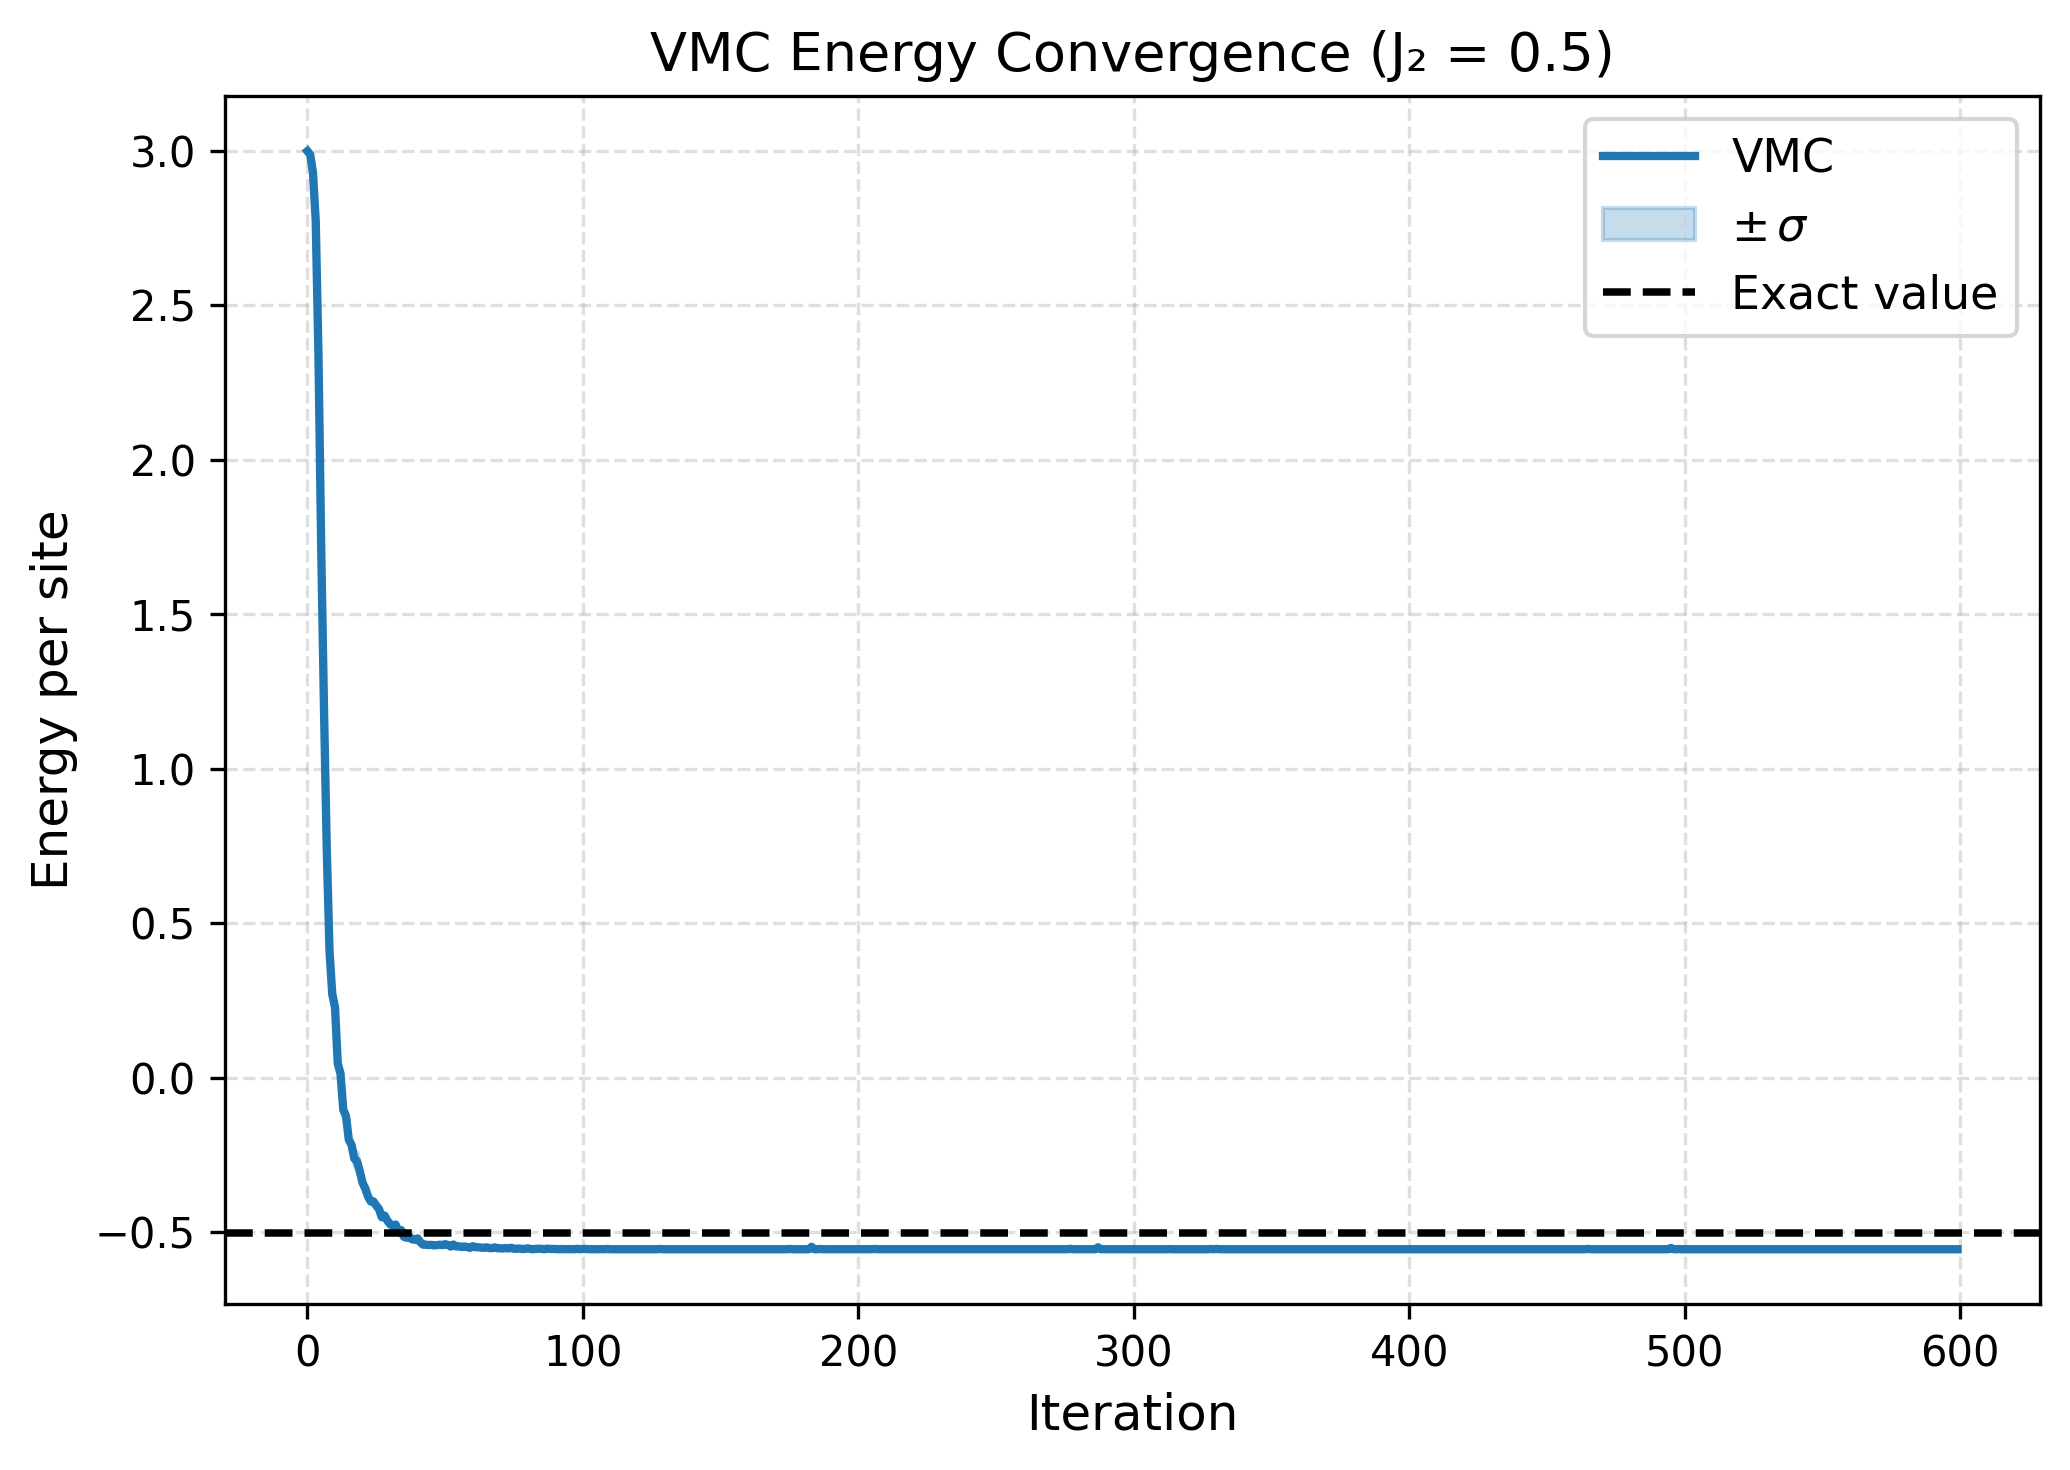

In [39]:
import matplotlib.pyplot as plt

# Data
iters = E_hist.iters
energy_site = E_hist.Mean.real / lattice.n_nodes
energy_err_site = E_hist.Sigma.real / lattice.n_nodes

# Exact (paper) value
E_real = -0.50381   # energy per site (J2 = 0.5)

fig, ax = plt.subplots(figsize=(7, 5), dpi=300)

# VMC energy
ax.plot(
    iters,
    energy_site,
    linewidth=2,
    color="tab:blue",
    label="VMC"
)

# Error band
ax.fill_between(
    iters,
    energy_site - energy_err_site,
    energy_site + energy_err_site,
    color="tab:blue",
    alpha=0.25,
    label=r"$\pm\,\sigma$"
)

# Exact reference line
ax.axhline(
    E_real,
    color="black",
    linestyle="--",
    linewidth=1.8,
    label="Exact value"
)

# Labels
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Energy per site", fontsize=12)
ax.set_title("VMC Energy Convergence (J₂ = 0.5)", fontsize=13)

ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

